In [ ]:
# code from https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os

from os import listdir
import imageio

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [44]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [4]:
# instead of MNIST dataset, I am using my tiny patches dataset

In [5]:
base_dir = '/scratch/image_datasets/1_for_learned_sift/ridiculously_small'

train_data_dir      = base_dir + '/patches/train'
validation_data_dir = base_dir + '/patches/validation'
# test_data_dir       = base_dir + '/patches/test'

train_descrs_dir      = base_dir + '/descriptors_angles/train'
validation_descrs_dir = base_dir + '/descriptors_angles/validation'
# test_descrs_dir       = base_dir + '/descriptors_angles/test'

In [6]:
def loading_data(dir_patches, dir_descrs):
    files_patches = listdir(dir_patches + '/class0')
    files_patches.sort()
    
    files_descrs = listdir(dir_descrs + '/class0')
    files_descrs.sort()
    
    assert len(files_patches) == len(files_descrs), "The number of patches doesn't match the number of descriptors."

    patches = []
    descrs = []

    
    for file_patch, file_descr in zip(files_patches, files_descrs):
        patch = imageio.imread(dir_patches + '/class0/' + file_patch)
#         print(patch.shape)
        if patch.shape[0] == 31:
            patches.append(patch)
            descr = np.load(dir_descrs + '/class0/' + file_descr)
            descrs.append(descr)
#         elif image.shape[0] == 19:
#             temp_count19 += 1
        
        

    patches = np.array(patches)
    patches = patches.astype(np.float64) / 255
    
    descrs = np.array(descrs)
    descrs = (descrs.astype(np.float64) / 255)
    print("patches", patches.shape, "  descrs", descrs.shape)
    
    return patches, descrs

In [7]:
x_train, y_train = loading_data(train_data_dir, train_descrs_dir)
x_test, y_test = loading_data(validation_data_dir, validation_descrs_dir)

patches (35, 31, 31)   descrs (35, 129)
patches (25, 31, 31)   descrs (25, 129)


In [33]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [34]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [35]:
# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

In [36]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [37]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [38]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

In [39]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

In [40]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_6 (Dense)              (None, 784)               402192    
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


In [41]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')
vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [42]:
models = (encoder, decoder)
data = (x_test, y_test)

reconstruction_loss = binary_crossentropy(inputs, outputs)

reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# plot_model(vae,
#            to_file='vae_mlp.png',
#            show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 403972    
_________________________________________________________________
decoder (Model)              (None, 784)               403728    
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


In [43]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))
vae.save_weights('vae_mlp.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 7s 116us/step - loss: 194.8402 - val_loss: 170.8297
Epoch 2/50
60000/60000 [==============================] - 10s 161us/step - loss: 168.5041 - val_loss: 166.9525
Epoch 3/50
60000/60000 [==============================] - 14s 239us/step - loss: 165.5029 - val_loss: 164.8543
Epoch 4/50
60000/60000 [==============================] - 14s 241us/step - loss: 163.3852 - val_loss: 162.8671
Epoch 5/50
60000/60000 [==============================] - 14s 232us/step - loss: 161.5429 - val_loss: 160.7706
Epoch 6/50
60000/60000 [==============================] - 14s 233us/step - loss: 159.9808 - val_loss: 159.6900
Epoch 7/50
60000/60000 [==============================] - 14s 233us/step - loss: 158.6065 - val_loss: 158.2849
Epoch 8/50
60000/60000 [==============================] - 14s 236us/step - loss: 157.5066 - val_loss: 157.3042
Epoch 9/50
60000/60000 [==============================] - 14s 2

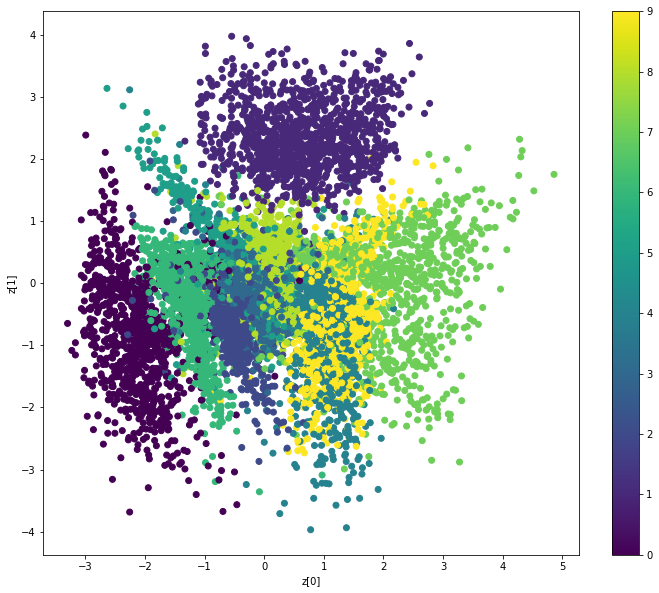

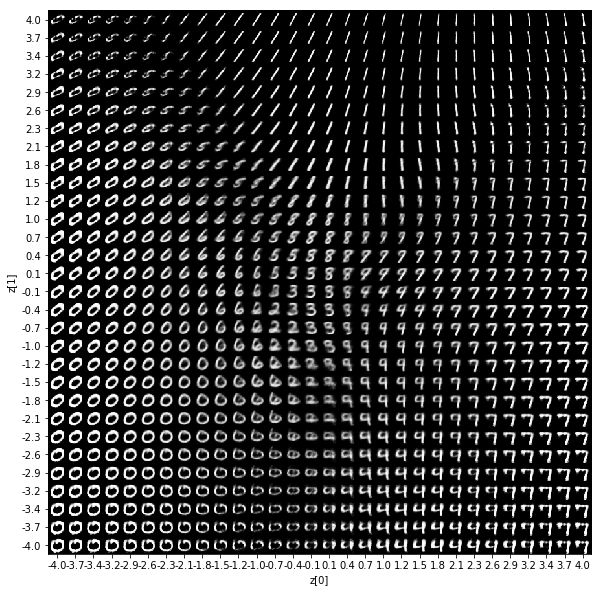

In [45]:
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae")